# Plant Height Geospatial Tutorial

Welcome to the plant height geospatial tutorial! This will analyze height for regions in a geojson shapefile using regional percentiles. The example data used in this tutorial comes from NDSU [BisonFly](https://github.com/filipematias23/Bison-Fly) showing how to analyze geospatial data in R. 

If you would like to use the same example data, [the zip file from BisonFly containing the relevant RGBs and DSMs is available for download here.](https://drive.google.com/file/d/1_Uj3oaiSv31WpbGyyUCfKiKhAqQ_jPUN/view) Once you have downloaded the zip file, run the code below to add the folder to your local notebook.

*Adapted to `plantcv-geospatial` by Eliza Seigel*

Updated May 2025

## Import libraries and images into the notebook

In [1]:
# Optional: Unzip the BisonFly data locally to your notebook.
import zipfile as zf
files = zf.ZipFile("/Users/<YOUR_USERNAME>/Downloads/NDSU_WheatData_UAV_2021.zip", 'r')
files.extractall('BisonFly')
files.close()

In [3]:
# Set the notebook display method.
%matplotlib widget
# If widget is not working, then change to inline

#Import libraries
import os
import cv2
import napari
import plantcv.plantcv as pcv
import plantcv.geospatial as gcv

# Plot debug images to the notebook
pcv.params.debug = "plot"

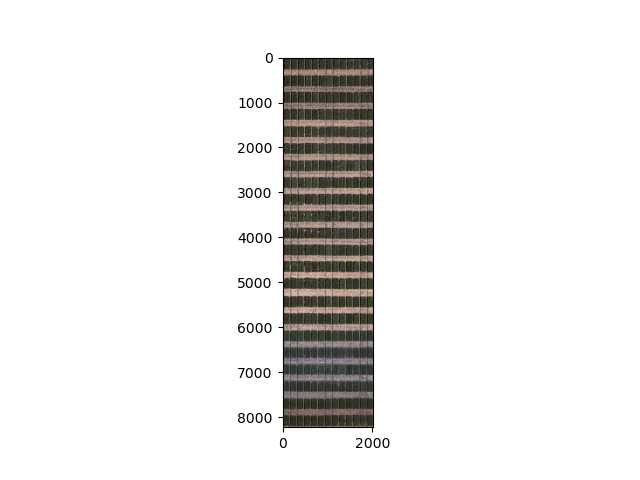

In [4]:
# First, we are going to read in the image we want to use. Make sure this is an RGB image. 'Folder' is the folder containing your RGBs and DSMs. If you used the code above to download the BisonFly zip file, replace 'folder' with 'BisonFly' and 'RGB_image' with your desired image.
geoimg = gcv.read_geotif("./BisonFly/RGB/EX_10_DAP_52_2021_Casselton_YT_06-28_rgb.tif",
                     bands="r,g,b")



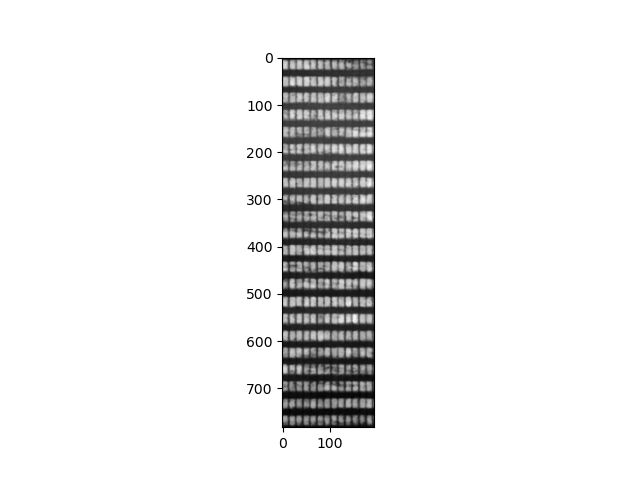

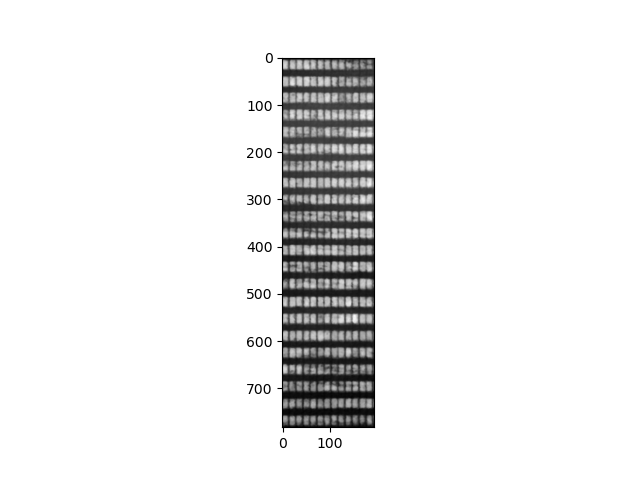

In [5]:
# Next we are going to read in the DSM that will be used in our function.
img, _, _ = pcv.readimage("./BisonFly/DSM/EX_10_DAP_52_2021_Casselton_YT_06-28_dem.tif")

# We will transform the image so downstream functions can successfully create a plant mask.
img = pcv.transform.rescale(gray_img = img, min_value=0, max_value=255)


## Make a plant mask
We will make a binary mask from the DSM image.


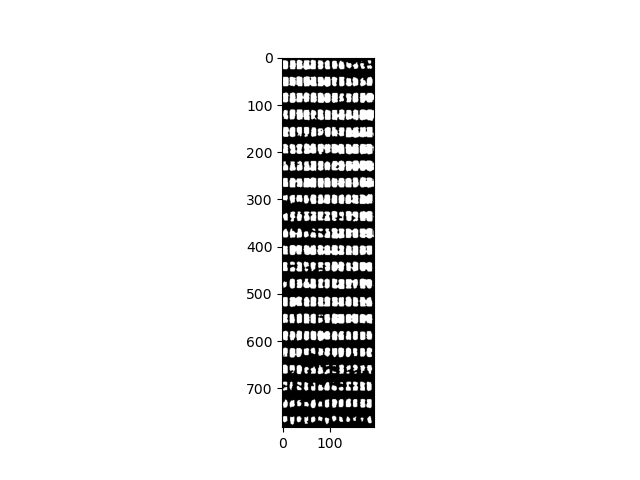

In [6]:
plant_mask = pcv.threshold.binary(gray_img = img, threshold=125, object_type="light")

## Create a shapefile interactively with Napari
This function opens Napari, where you can create layers. Please see the images and instructions below before you run this code.


In [7]:
img = geoimg
viewer = napari.Viewer()
viewer.add_image(img.pseudo_rgb)

viewer.add_points()

<Points layer 'Points' at 0x1737d0490>

Congratulations, you've opened Napari! **Starting in the top left corner**, make 4 points in each corner of your field going clockwise. Don't worry about perfectly aligning the points of the rectangle, the 4 points just have to contain the whole field. 

![](https://raw.githubusercontent.com/danforthcenter/plantcv-geospatial-tutorial-plant-height/main/img/tutorial-imgs/img2.png)

## Save the points as a geojson

This code saves the '4cornerpoints' layer as a geojson. The output location is the path to the folder where you want to save the geojson.


In [9]:
gcv.points_to_geojson(img, viewer, out_path="./shapefile/4cornerpoints.geojson")

## Create flexible grid layout as a geojson
Now we will do the same thing, except instead of creating 4 corner points, you will now be creating points that indicate where your plots are. Please see the images and instructions below before you run this code.


In [10]:
img=geoimg
viewer = napari.Viewer()
viewer.add_image(img.pseudo_rgb)

viewer.add_points()

<Points layer 'Points' at 0x17a3a0d90>

Mark each of the plots. **Make your points at the top left corner of each of your plots.** If your plots are spaced evenly, there is the option to auto-grid by making a point at the top left of the entire row and increasing num_rows in the code below. However, the example image below is marked as if a gridcell needs to be individually placed.

![](https://raw.githubusercontent.com/danforthcenter/plantcv-geospatial-tutorial-plant-height/main/img/tutorial-imgs/img3.png)

In [11]:
# This code saves the 'gridpoints' layer as a geojson.
gcv.points_to_geojson(img, viewer, out_path="./shapefile/gridpoints.geojson")

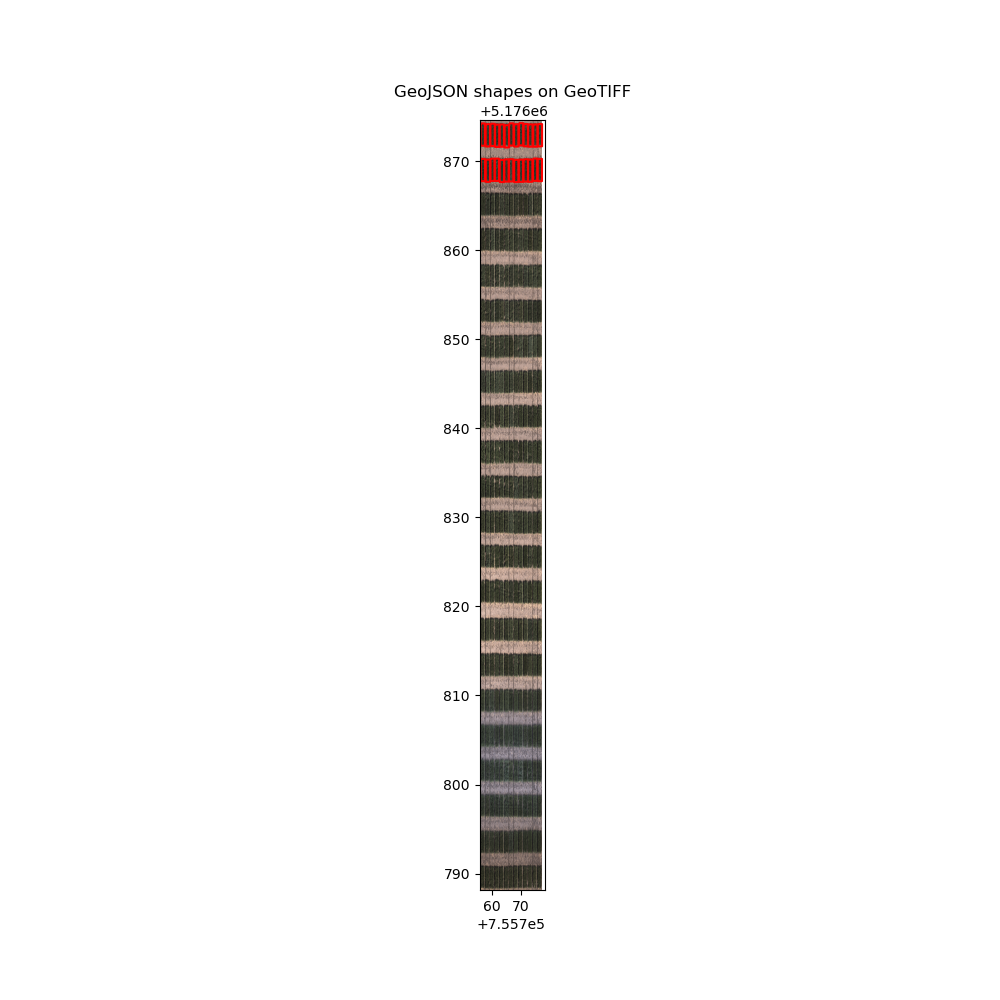

In [7]:
# The gridcells function creates grids from the designated plot points. Adjust the dimensions of the range length and row length as needed.
gridcells = gcv.shapes.flexible(img=geoimg, field_corners_path="./shapefile/4cornerpoints.geojson", 
                                plot_geojson_path="./shapefile/gridpoints.geojson", 
                                out_path="./shapefile/gridcells.geojson", num_rows=1,
                                range_length=2.5, row_length=1.5)

## Estimate height of each plot 

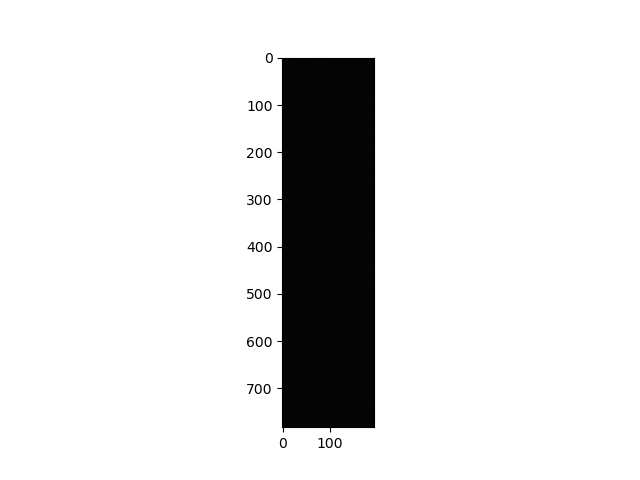

In [8]:
# Read DSM in as geospatial data.
dsm = gcv.read_geotif(filename="./BisonFly/DSM/EX_10_DAP_52_2021_Casselton_YT_06-28_dem.tif", bands=[0])


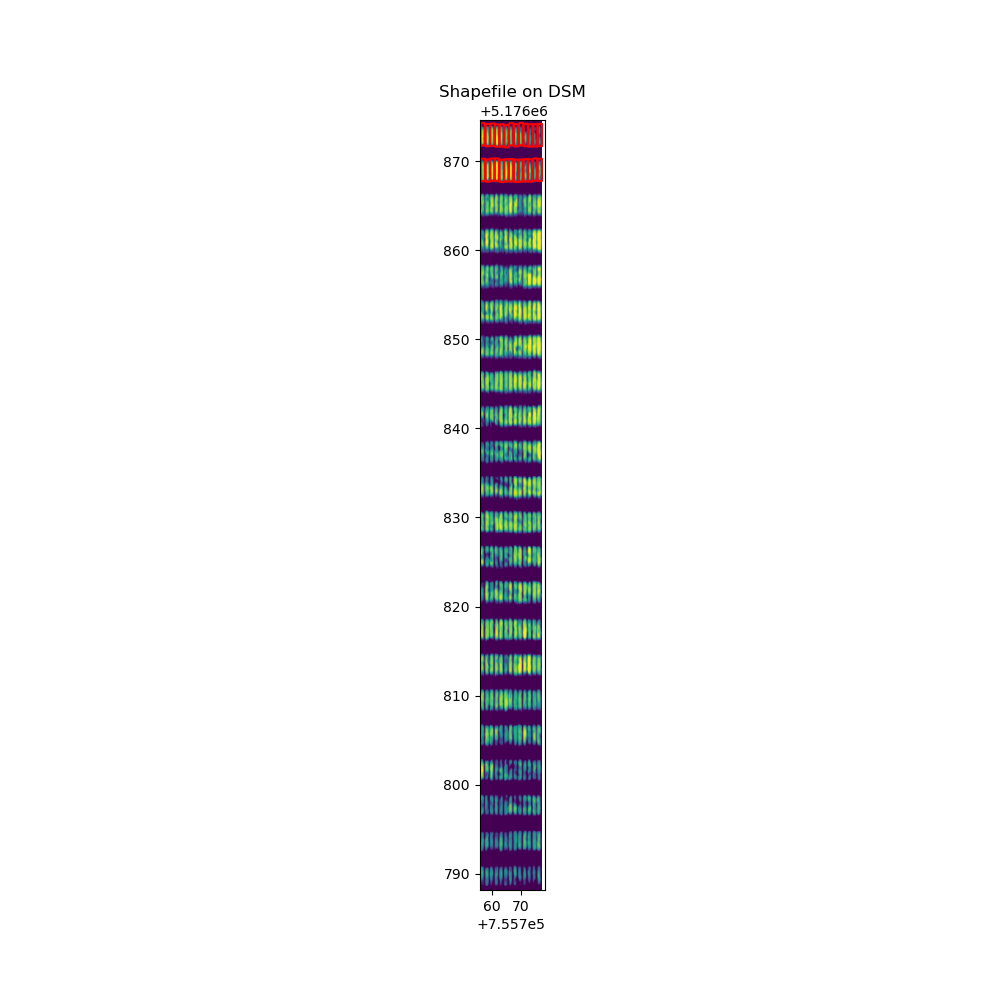

In [9]:
# Analyze height for each region in the geojson.
bounds = gcv.analyze.height_percentile(dsm=dsm,
                           geojson="./shapefile/gridcells.geojson",
                           lower=25,
                           upper=90,
                           label="default")



## Access output data and save out to file 

In [17]:
# To access individual observation values:
print(pcv.outputs.observations["default_0"]["plant_height"]["value"])
print(pcv.outputs.observations["default_0"]["plant_height"]["scale"])


0.358062744140625
metre


In [ ]:
#To save the outputs as a shapefile: 
pcv.outputs.save_results(filename="./height_results.json")    
